In [1]:
!nvidia-smi

Thu Jan 17 11:44:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:E2:00.0 Off |                    0 |
| N/A   32C    P0    50W / 350W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

!pip install --upgrade keras tensorflow-gpu
!pip install tqdm

from tqdm import tqdm
import pandas as pd
import json
from shutil import copyfile, rmtree

import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops

from keras.applications import *

from keras.layers import Conv2D, Dense, Flatten, Input, Lambda, MaxPooling2D, Input, GlobalMaxPooling2D, Dropout
from keras.models import Model
import sys

import random
!pip install imgaug
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

from metric_learning import triplet_semihard_loss



import skimage
from distutils.version import LooseVersion



tqdm.pandas()
DATA_SRC_DIR = '/home/jovyan/data/humpback/train/'
DATA_PREPROCESSED = '/home/jovyan/data/humpback/preprocessed_train'


Requirement already up-to-date: keras in /opt/conda/lib/python3.6/site-packages (2.2.4)
Requirement already up-to-date: tensorflow-gpu in /opt/conda/lib/python3.6/site-packages (1.12.0)


Using TensorFlow backend.


## Sanity Check

In [3]:
df = pd.read_csv('bounding_boxes.csv')
bboxes = dict()
for i, row in df.iterrows():
    bboxes[row['Image']] = [int(row['y0']), int(row['y1']), int(row['x0']), int(row['x1'])]

In [4]:
df = pd.read_csv('tail_keypoints.csv')
keypoints = dict()
for i, row in df.iterrows():
    keypoints[row['image']] = [int(row['left_x']), int(row['left_y']), int(row['mid_x']), int(row['mid_y']), int(row['right_x']), int(row['right_y'])]

In [5]:
bboxes['e2deae874.jpg']

[129, 514, 121, 878]

In [6]:
import tensorflow as tf

def tf_print(op, tensors, message=None):
    def print_message(x):
        sys.stdout.write(message + " %s\n" % x)
        return x

    prints = [tf.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]
    with tf.control_dependencies(prints):
        op = tf.identity(op)
    return op

def _pairwise_distances(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
    feature: 2-D Tensor of size [number of data, feature dimension].
    squared: Boolean, whether or not to square the pairwise distances.
    Returns:
    pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    
    pairwise_distances_squared = math_ops.add(
      math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
      math_ops.reduce_sum(
          math_ops.square(array_ops.transpose(feature)),
          axis=[0],
          keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                  array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
             pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
      pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
      array_ops.ones([num_data]))
    
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    
    return pairwise_distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(labels, tf.transpose(labels))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(labels, tf.transpose(labels))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)
    #pairwise_dist = tf_print(pairwise_dist, [pairwise_dist], '\n pairwise: ')


    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = 1e-3*anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss


def batch_hard_triplet_loss(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    #hardest_positive_dist = tf_print(hardest_positive_dist, [hardest_positive_dist], '\n pos embedding: ')
    
    
    
    
    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    #hardest_negative_dist = tf_print(hardest_negative_dist, [hardest_negative_dist], '\n neg embedding: ')

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    #triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)
    triplet_loss = tf.maximum(1e-1*hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

def hardest_negative_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)
    
    maximum = math_ops.reduce_max(pairwise_dist, keepdims=True)
    result = math_ops.reduce_min(
        math_ops.multiply(pairwise_dist - maximum, mask_anchor_negative),
        keepdims=True) + maximum
    
    return result

def mean_negative_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    anchor_negative_dist = tf.multiply(pairwise_dist, mask_anchor_negative)
    
    return tf.reduce_sum(anchor_negative_dist)/tf.reduce_sum(mask_anchor_negative)

def num_neg_pairs(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """


    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    
    return tf.reduce_sum(mask_anchor_negative)

def hardest_positive_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    anchor_positive_dist = tf.multiply(pairwise_dist, mask_anchor_positive)
    
    return tf.reduce_max(anchor_positive_dist)

def mean_positive_dist(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    anchor_positive_dist = tf.multiply(pairwise_dist, mask_anchor_positive)
    
    return tf.reduce_sum(anchor_positive_dist)/tf.reduce_sum(mask_anchor_positive)

def num_pos_pairs(labels, embeddings, margin = 1.2, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """

    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    return tf.reduce_sum(mask_anchor_positive)

In [7]:
weights = 'test.h5'
weights = '/home/jovyan/weights.214'

model = keras.models.load_model(weights, custom_objects=
                                {'batch_hard_triplet_loss': batch_hard_triplet_loss,
                                 'batch_all_triplet_loss': batch_all_triplet_loss,
                                 'hardest_negative_dist': hardest_negative_dist,
                                 'hardest_positive_dist': hardest_positive_dist,
                                 'mean_negative_dist': mean_negative_dist,
                                 'mean_positive_dist': mean_positive_dist,
                                 'triplet_semihard_loss': triplet_semihard_loss,
                                 'num_pos_pairs': num_pos_pairs,
                                 'num_neg_pairs': num_neg_pairs})

In [8]:
def flatten_tail(im, lx, ly, mx, my, rx, ry, target_size=(512, 512)):    
    M = cv2.getAffineTransform(
        np.array([(lx, ly), (mx, my), (rx, ry)]).astype(np.float32),
        np.array([(20, 20), ((target_size[1] - 1)//2, (target_size[0] - 1)//2), ((target_size[1] - 1) - 20, 20)]).astype(np.float32),
    )
    dst = cv2.warpAffine(im, M, target_size[::-1])
    
    return dst

In [9]:
def read_image(path, dim, bboxes = None, keypoints = None):
    img = cv2.imread(path)[:,:,::-1]

    keyp = keypoints[path.split('/')[-1]]
    #img = flatten_tail(img, keyp[0], keyp[1], keyp[2], keyp[3], keyp[4], keyp[5], target_size=(dim,dim))
    
    
    if bboxes is not None:
        bbox = bboxes[path.split('/')[-1]]
        #img = img[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    #img = resize_image(img, min_dim = self.dim, max_dim=self.dim)
    img = cv2.resize(img, (dim, dim))

    return img/255
    

In [10]:
size = 336
embedding_size = 1024
reg = 1e-4
batch_size = 16

MODEL_DIR = '/home/jovyan/models/humpback/triplet'





In [11]:
df_train = pd.read_csv('/home/jovyan/data/humpback/train.csv')
df_train = df_train[df_train['Id'] != 'new_whale']

df_train['abs_path'] = df_train['Image'].apply(lambda x: os.path.join(DATA_SRC_DIR, x))
df_train['embedding'] = df_train['abs_path'].progress_apply(lambda x: model.predict(np.array([read_image(x, keypoints=keypoints, dim = size)])))

100%|██████████| 15697/15697 [05:01<00:00, 54.46it/s]


In [12]:
backup = df_train

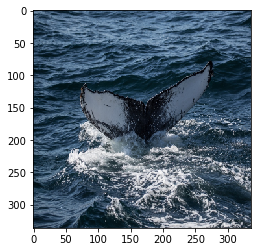

In [13]:
plt.imshow(read_image(df_train['abs_path'][0], keypoints=keypoints,dim = size))

In [14]:
#df_train = pd.DataFrame(df_train.groupby(['Id'])['embedding'].progress_apply(np.mean))
#df_train['Id'] = df_train.index

In [15]:
df_train

,Image,Id,abs_path,embedding
0,0000e88ab.jpg,w_f48451c,/home/jovyan/data/humpback/train/0000e88ab.jpg,"[[1.4536234e-07, 0.00036040964, 2.8706085e-13,..."
1,0001f9222.jpg,w_c3d896a,/home/jovyan/data/humpback/train/0001f9222.jpg,"[[1.9873345e-09, 8.324314e-09, 2.3685823e-08, ..."
2,00029d126.jpg,w_20df2c5,/home/jovyan/data/humpback/train/00029d126.jpg,"[[1.7715523e-10, 0.00036470892, 0.00057501806,..."
6,000a6daec.jpg,w_dd88965,/home/jovyan/data/humpback/train/000a6daec.jpg,"[[1.1592741e-09, 1.716657e-07, 1.09176584e-13,..."
8,0016b897a.jpg,w_64404ac,/home/jovyan/data/humpback/train/0016b897a.jpg,"[[1.0175918e-09, 0.00030793558, 1.619545e-13, ..."
9,001c1ac5f.jpg,w_a6f9d33,/home/jovyan/data/humpback/train/001c1ac5f.jpg,"[[5.7666916e-10, 0.0004839646, 3.1277505e-06, ..."
10,001cae55b.jpg,w_581ba42,/home/jovyan/data/humpback/train/001cae55b.jpg,"[[2.1132012e-06, 0.0001961777, 0.09158341, 2.6..."
16,00355ff28.jpg,w_cb622a2,/home/jovyan/data/humpback/train/00355ff28.jpg,"[[3.2371694e-10, 3.369138e-09, 1.2286745e-07, ..."
17,00357e37a.jpg,w_d3b46e7,/home/jovyan/data/humpback/train/00357e37a.jpg,"[[1.7810572e-06, 1.6753747e-05, 2.7330264e-08,..."
21,00442c882.jpg,w_8cad422,/home/jovyan/data/humpback/train/00442c882.jpg,"[[3.1911588e-07, 1.2241853e-07, 6.933483e-08, ..."


In [16]:
data = np.squeeze(np.stack(df_train['embedding']))
from scipy import spatial
tree = spatial.KDTree(data)

In [36]:
tree.query(np.squeeze(np.stack(df_train[df_train['Id'] == 'w_23a388d']['embedding'])),50)
#df_train[df_train['Id'] == 'w_23a388d']['embedding']

(array([[0.        , 0.69944197, 0.73049588, ..., 0.84134968, 0.84232464,
         0.8462113 ],
        [0.        , 0.40564321, 0.40662975, ..., 0.66062247, 0.66078788,
         0.66079128],
        [0.        , 0.24799798, 0.3685385 , ..., 0.58492721, 0.59253221,
         0.59287624],
        ...,
        [0.        , 0.57478792, 0.63627951, ..., 0.76603715, 0.7661966 ,
         0.76672176],
        [0.        , 0.34298679, 0.36205647, ..., 0.56883988, 0.56888014,
         0.57622474],
        [0.        , 0.45658262, 0.46905743, ..., 0.67472779, 0.67561587,
         0.67853534]]), array([[  173,  7926,  4628, ...,  5022, 13104,  4830],
        [  185,  8724, 10269, ..., 14680, 11500, 14715],
        [  236, 12692,  2552, ..., 14158, 10802,    82],
        ...,
        [14421,  7687,  1697, ..., 14715,  4643, 13691],
        [14623,  8718,  3660, ..., 14373, 13824,  2878],
        [15181,  7003, 12732, ..., 10447,  9112,  8553]]))

In [18]:
DATA_SRC_TEST_DIR = '/home/jovyan/data/humpback/test/'

In [19]:
df_test = pd.DataFrame()
df_test['abs_path'] = glob(os.path.join(DATA_SRC_TEST_DIR, '*'))
df_test['embedding'] = df_test['abs_path'].progress_apply(lambda x: model.predict(np.array([read_image(x, keypoints= keypoints, bboxes=bboxes, dim = size)])))

100%|██████████| 7960/7960 [02:35<00:00, 51.14it/s]


In [20]:
df_test['query'] = df_test['embedding'].progress_apply(lambda x: tree.query(x,5))

df_test['pred'] = df_test['query'].progress_apply(lambda x: x[1])
df_test['dist'] = df_test['query'].progress_apply(lambda x: x[0])
df_test['closest_dist'] = df_test['dist'].progress_apply(lambda x: x[0][0])


100%|██████████| 7960/7960 [00:00<00:00, 581122.67it/s]


In [21]:
df_test['closest_dist'].quantile(0.723)

0.5301383293078129

In [22]:
def get_classes(row, treshold = 0.9):
    classes = ""
    new_whale_used = False
    i = 0
    num_results = 0
    while num_results < 5:
                
        if row['dist'][0][i] > treshold and not new_whale_used:
            classes += "new_whale "
            num_results += 1
            new_whale_used = True
        else:
            while df_train.iloc[row['pred'][0][i]]['Id'] in classes and i < 45:
                i += 1
                
            classes += df_train.iloc[row['pred'][0][i]]['Id']
            classes += " "
            num_results += 1
            i += 1
            
    return classes[:-1]
    
    

In [23]:
df_test['dist'][201]

array([[0.60576544, 0.6142647 , 0.61578074, 0.63048731, 0.63383096,
        0.63916855, 0.65644883, 0.66074201, 0.66778761, 0.67100406,
        0.67975272, 0.68322648, 0.68503906, 0.69369967, 0.69490605,
        0.70138215, 0.70617257, 0.70969122, 0.71033729, 0.71311408,
        0.71394158, 0.71421436, 0.71597209, 0.71688564, 0.71689283,
        0.72167585, 0.72177578, 0.72204498, 0.730166  , 0.73059203,
        0.73073063, 0.73092099, 0.73135176, 0.73147872, 0.73233512,
        0.73352139, 0.73539501, 0.73754006, 0.7389921 , 0.74067478,
        0.74177009, 0.74227865, 0.74395253, 0.74429824, 0.74619568,
        0.74631421, 0.74632124, 0.74668857, 0.74678934, 0.74801496]])

In [34]:
df_test

,abs_path,embedding,query,pred,dist,closest_dist,Id,Image
0,/home/jovyan/data/humpback/test/149db03e1.jpg,"[[7.2049825e-06, 2.3025189e-08, 4.5252438e-07,...","([[0.33333977181455143, 0.37383909139621946, 0...","[[15695, 5243, 10945, 6788, 7341, 42, 14429, 7...","[[0.33333977181455143, 0.37383909139621946, 0....",0.333340,w_bd1c3d5 w_4460861 w_939423d w_1531bf5 w_9614e63,149db03e1.jpg
1,/home/jovyan/data/humpback/test/a65a0df2c.jpg,"[[5.8523697e-10, 4.7948475e-07, 1.8198386e-07,...","([[0.5601310649833766, 0.5656287809635477, 0.5...","[[5864, 5322, 750, 15064, 720, 14720, 3965, 12...","[[0.5601310649833766, 0.5656287809635477, 0.59...",0.560131,new_whale w_cb622a2 w_f9d1114 w_bf960fa w_48d22a3,a65a0df2c.jpg
2,/home/jovyan/data/humpback/test/3bebe67aa.jpg,"[[0.003065783, 3.8886782e-07, 0.00018406166, 1...","([[0.4530071565702742, 0.5253556250503693, 0.5...","[[2339, 289, 3389, 272, 12124, 10463, 9867, 11...","[[0.4530071565702742, 0.5253556250503693, 0.54...",0.453007,w_9fecf9d w_40a6c9c new_whale w_cb9f118 w_234713b,3bebe67aa.jpg
3,/home/jovyan/data/humpback/test/c84b9f02b.jpg,"[[9.5873675e-06, 5.018174e-07, 7.243829e-08, 2...","([[0.5090131796871121, 0.5346109159503979, 0.5...","[[7683, 5044, 5646, 5402, 2388, 2303, 15054, 9...","[[0.5090131796871121, 0.5346109159503979, 0.53...",0.509013,w_a743e09 new_whale w_22f2567 w_b44e89d w_c1715f5,c84b9f02b.jpg
4,/home/jovyan/data/humpback/test/61d8cd03e.jpg,"[[0.010323932, 2.875721e-08, 5.241267e-10, 8.0...","([[0.44383300152748434, 0.5433071646161265, 0....","[[8143, 1305, 12001, 14855, 11481, 10013, 6923...","[[0.44383300152748434, 0.5433071646161265, 0.5...",0.443833,w_361a865 new_whale w_32043b0 w_401f5a1 w_fa3a41f,61d8cd03e.jpg
5,/home/jovyan/data/humpback/test/221486ece.jpg,"[[1.8361558e-10, 1.3407653e-09, 2.567518e-11, ...","([[0.49877829605278473, 0.5154385084963623, 0....","[[6848, 4621, 13744, 5198, 7941, 4319, 7741, 6...","[[0.49877829605278473, 0.5154385084963623, 0.6...",0.498778,w_059d9e0 w_54fd73d new_whale w_cb50f6e w_352445a,221486ece.jpg
6,/home/jovyan/data/humpback/test/a7e466ba3.jpg,"[[8.907357e-06, 6.1744295e-06, 0.089940496, 4....","([[0.4349522830014774, 0.4352395893880837, 0.4...","[[2745, 4509, 342, 9713, 7654, 14603, 9813, 24...","[[0.4349522830014774, 0.4352395893880837, 0.44...",0.434952,w_9d86594 w_91f13fe w_38c8a8d w_03270e3 w_f3887f1,a7e466ba3.jpg
7,/home/jovyan/data/humpback/test/f6500c021.jpg,"[[7.344797e-08, 0.0005926336, 0.0017280988, 1....","([[0.4410030920716096, 0.4414240403092709, 0.4...","[[9335, 6012, 13990, 9701, 10307, 9928, 11100,...","[[0.4410030920716096, 0.4414240403092709, 0.46...",0.441003,w_10b4603 w_d3734df w_34afc43 w_2d5492b w_2b069ba,f6500c021.jpg
8,/home/jovyan/data/humpback/test/de2844bb0.jpg,"[[3.6916874e-06, 5.0775757e-06, 1.7219853e-06,...","([[0.31080925851217417, 0.3950588739557942, 0....","[[15520, 7318, 6534, 10085, 15320, 9062, 410, ...","[[0.31080925851217417, 0.3950588739557942, 0.3...",0.310809,w_659bdb8 w_af367c3 w_2f6d4a8 w_34434d1 w_f765256,de2844bb0.jpg
9,/home/jovyan/data/humpback/test/85143cf43.jpg,"[[0.032325916, 2.646567e-07, 1.4911356e-08, 1....","([[0.6991454784000205, 0.7027127010783865, 0.7...","[[14083, 2185, 5252, 4393, 2523, 10352, 2032, ...","[[0.6991454784000205, 0.7027127010783865, 0.71...",0.699145,new_whale w_efd6a16 w_11e90bc w_69c06ad w_1d8d7c3,85143cf43.jpg


In [37]:
df_test['Id'] = df_test.progress_apply(lambda x: get_classes(x, treshold = .8*df_test['closest_dist'].quantile(0.723)), axis =1)
df_test['Image'] = df_test['abs_path'].progress_apply(lambda x: x.split('/')[-1])

100%|██████████| 7960/7960 [00:00<00:00, 744423.73it/s]


In [38]:
df_submission = df_test[['Image','Id']]

In [39]:
df_submission.to_csv('sub1.csv', index = False)

In [28]:
df_submission

,Image,Id
0,149db03e1.jpg,w_bd1c3d5 w_4460861 w_939423d w_1531bf5 w_9614e63
1,a65a0df2c.jpg,new_whale w_cb622a2 w_f9d1114 w_bf960fa w_48d22a3
2,3bebe67aa.jpg,w_9fecf9d new_whale w_40a6c9c w_cb9f118 w_234713b
3,c84b9f02b.jpg,new_whale w_a743e09 w_22f2567 w_b44e89d w_c1715f5
4,61d8cd03e.jpg,w_361a865 new_whale w_32043b0 w_401f5a1 w_fa3a41f
5,221486ece.jpg,w_059d9e0 new_whale w_54fd73d w_cb50f6e w_352445a
6,a7e466ba3.jpg,w_9d86594 w_91f13fe w_38c8a8d w_03270e3 w_f3887f1
7,f6500c021.jpg,w_10b4603 w_d3734df w_34afc43 w_2d5492b w_2b069ba
8,de2844bb0.jpg,w_659bdb8 w_af367c3 w_2f6d4a8 w_34434d1 w_f765256
9,85143cf43.jpg,new_whale w_efd6a16 w_11e90bc w_69c06ad w_1d8d7c3


In [29]:
np.all(x[0][0][0@] == x[0][1][0])

SyntaxError: invalid syntax (<ipython-input-29-a000eff211d5>, line 1)

In [ ]:
plt.imshow(x[0][2])